In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from EvalTools import uncertainty_plot
import gc
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#optional parameters to only evaluate certain models
optional_dataset = 'topdata'
optional_tag = '0.5'
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if optional_dataset in f and optional_tag in f
                      and "Ensemble" not in f and "MCDO" not in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_best_topdata_nominal_0.5_baseline.h5
RESULTS_UQPFIN_best_topdata_nominal_0.5_slope_0.025_baseline.h5
RESULTS_UQPFIN_best_topdata_nominal_0.5_slope_0.05_baseline.h5
RESULTS_UQPFIN_best_topdata_nominal_0.5_slope_0.2_baseline.h5


In [6]:
use_std_unc = False

In [7]:
for modelname in result_files:
    model_results = {}
    mname = modelname[20:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    labels, preds, oods, probs, uncs, sums = f['labels'][:], f['preds'][:], f['oods'][:], f['probs'][:], f['uncs'][:], f['sums'][:]
    f.close()
    acc = accuracy_score(labels[~oods], preds[~oods])*100
    if "topdata" in mname:
        probs2=probs
    else:
        skiplabels = np.unique(labels[oods])
        probs2=np.delete(probs, skiplabels, 1)

    if probs2.shape[1] == 2:
        probs2 = probs2[:, 1]
    
    # misclassification detection vs anomaly detection
    if "baseline" in mname:
        oods = labels != preds
    
    # std
    if use_std_unc:
        sums = torch.from_numpy(sums).reshape(-1,1)
        probs = torch.from_numpy(probs)
        uncs = torch.sqrt(((probs*(1 - probs))/(sums + 1))).mean(1).numpy()
        mname += " (STD)"

    auc = roc_auc_score(oods, uncs) * 100
            
    this_file = os.path.join(saved_model_loc, modelname[8:-3])
    evaluator = ModelEvaluator(this_file)
    nparams = sum(p.numel() for p in evaluator.model.parameters())
    del evaluator, model_results
    gc.collect()
    
    print("{} \t\t Params: {}\t Accuracy: {:.2f}% \t AUROC: {:.2f}%".format(mname, nparams, acc, auc))    

topdata_nominal_0.5_baseline 		 Params: 96806	 Accuracy: 93.63% 	 AUROC: 90.23%
topdata_nominal_0.5_slope_0.025_baseline 		 Params: 96806	 Accuracy: 93.67% 	 AUROC: 89.95%
topdata_nominal_0.5_slope_0.05_baseline 		 Params: 96806	 Accuracy: 93.63% 	 AUROC: 90.26%
topdata_nominal_0.5_slope_0.2_baseline 		 Params: 96806	 Accuracy: 93.66% 	 AUROC: 90.39%


In [6]:
use_std_unc = True

jetclass_0_baseline


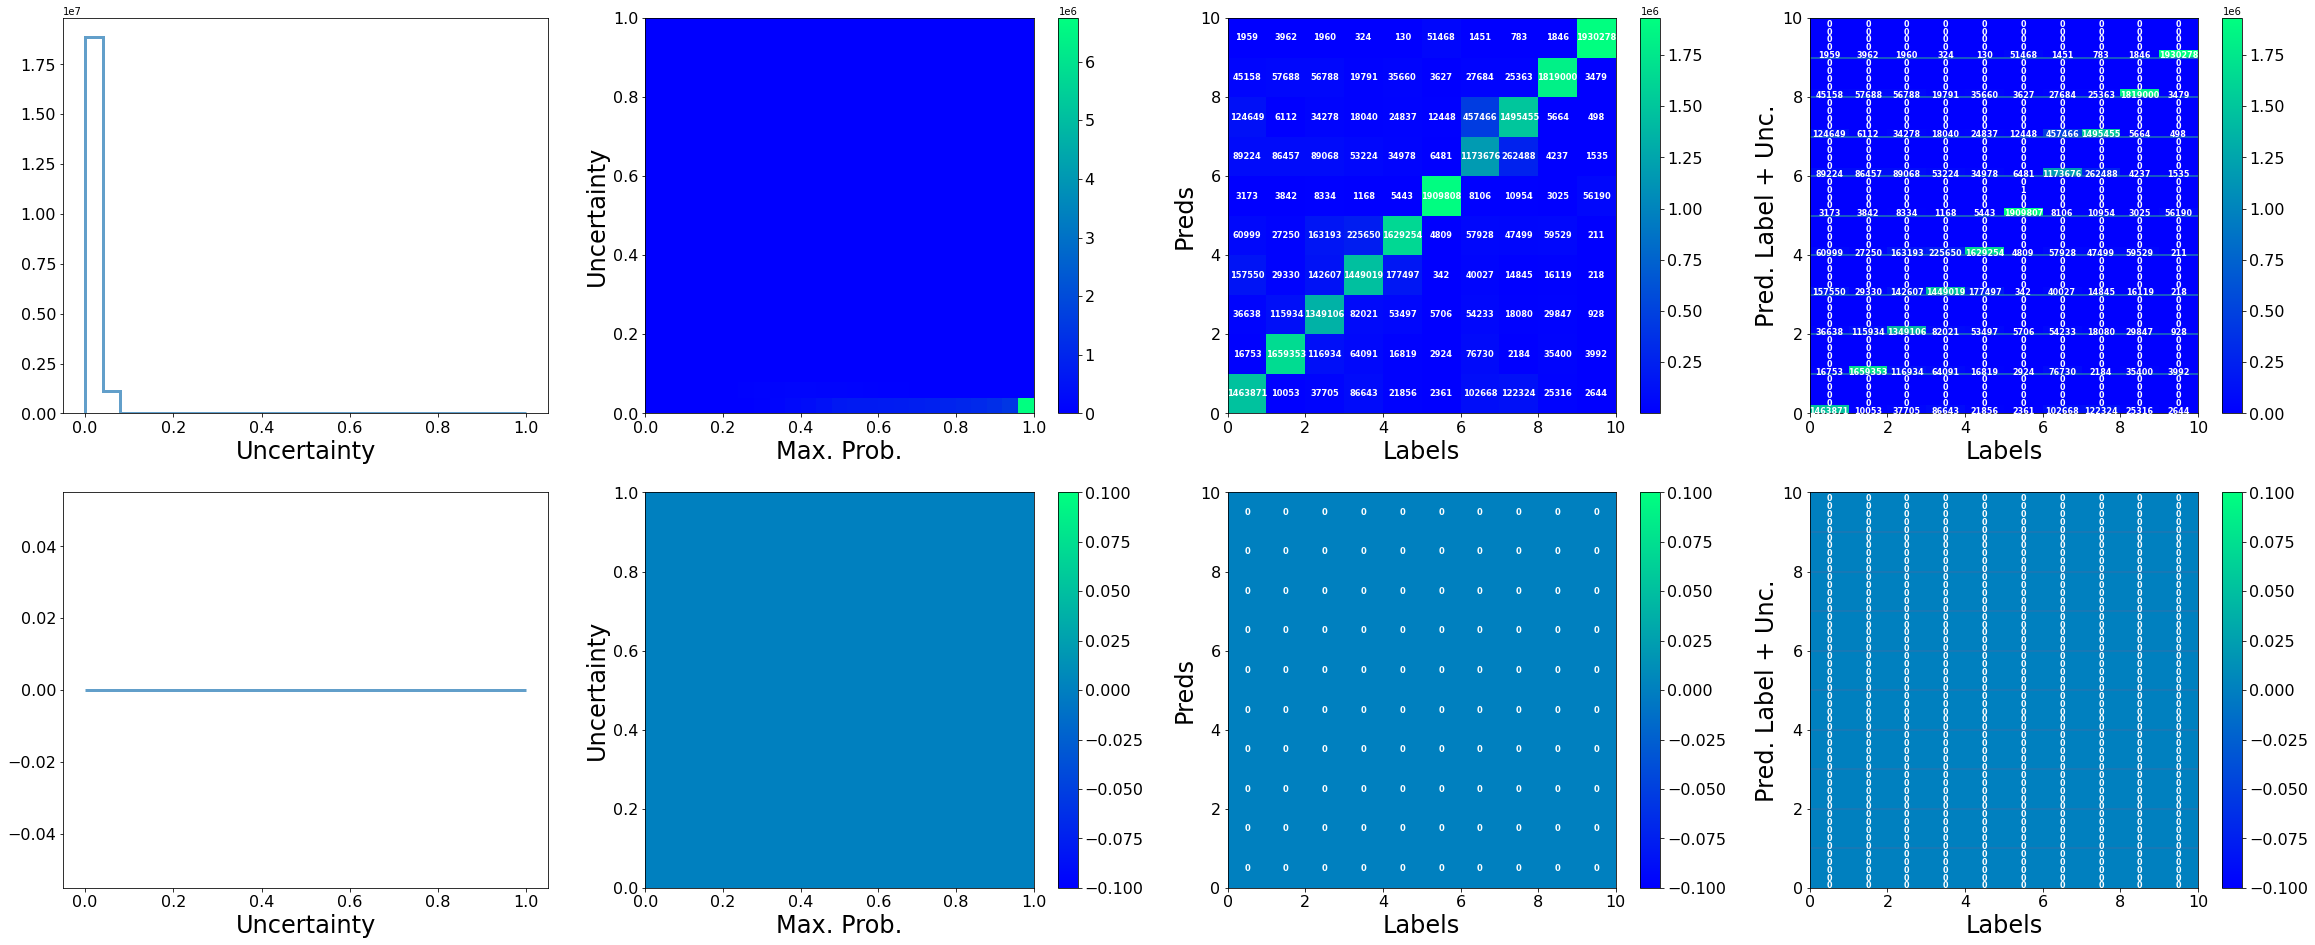

jetclass_0_skiph


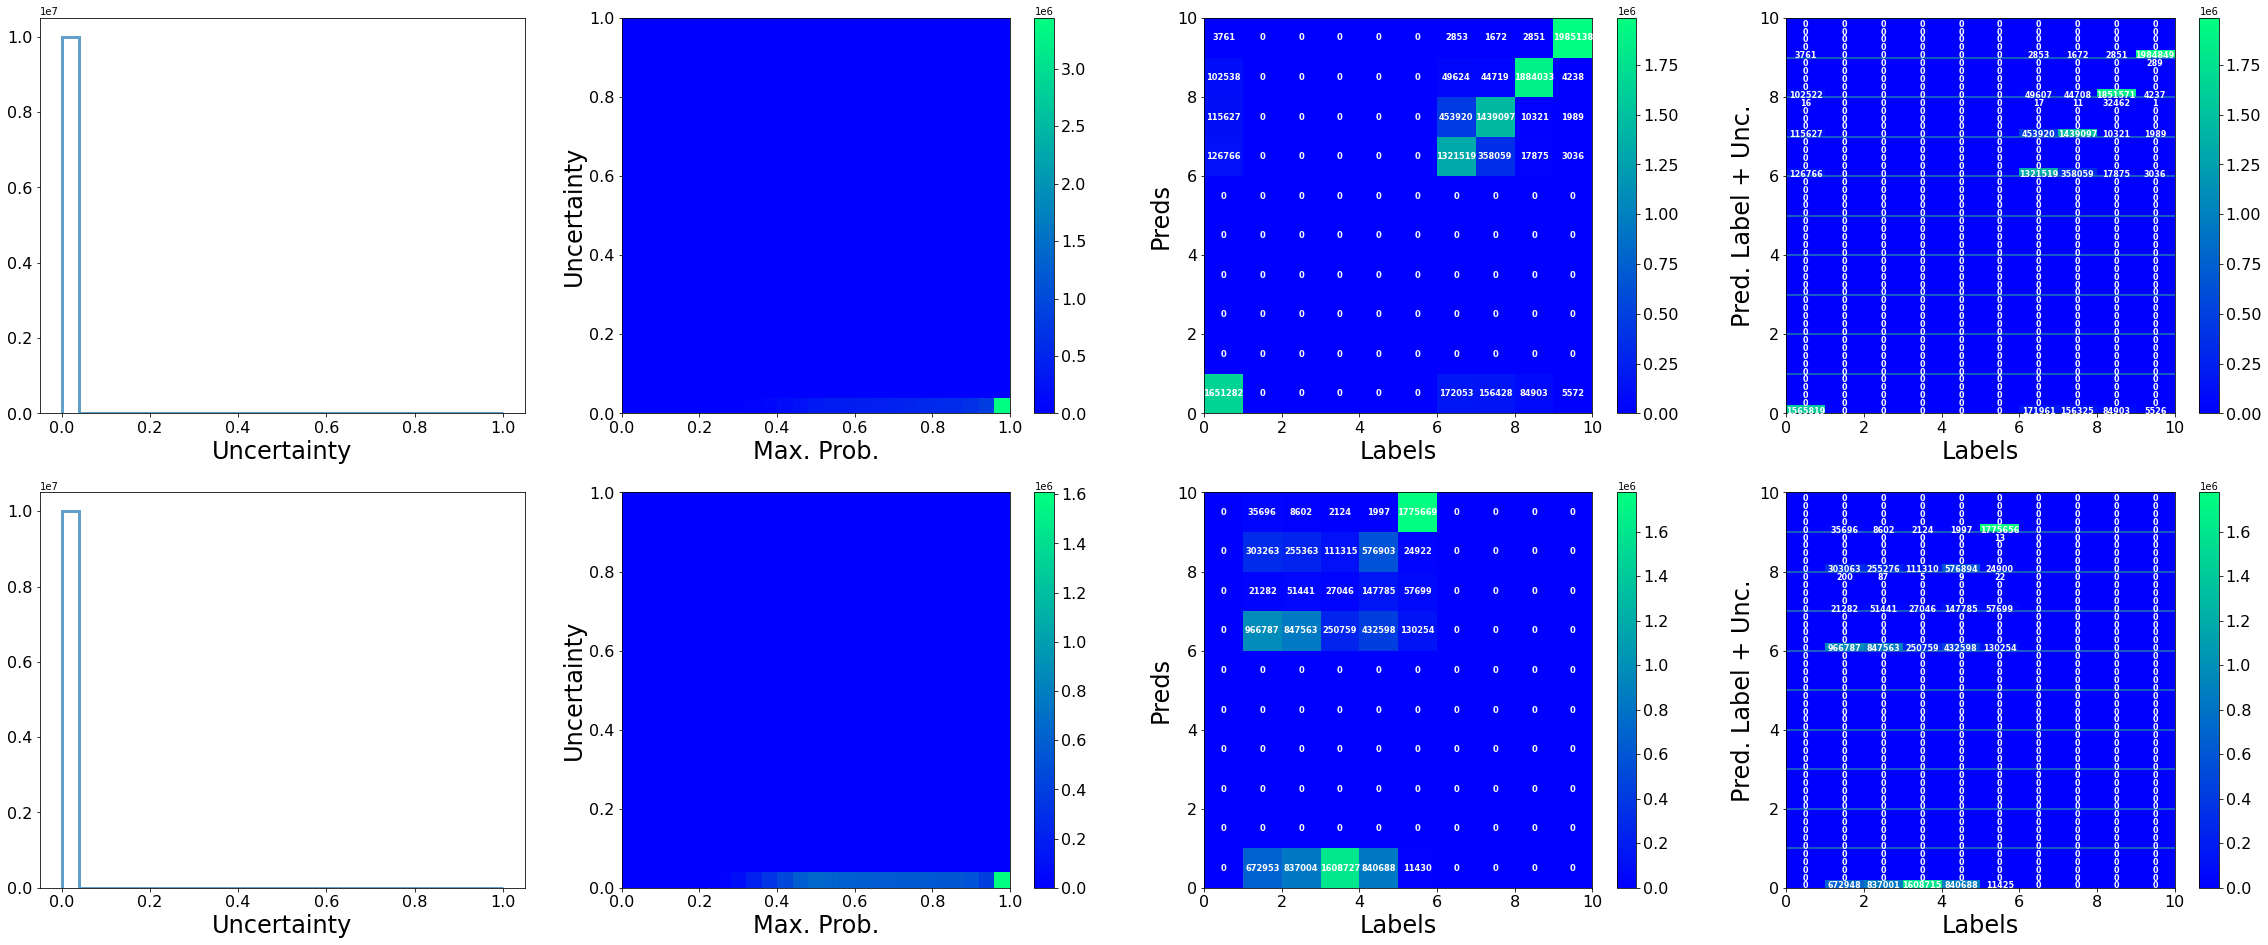

jetclass_0_skiptwz


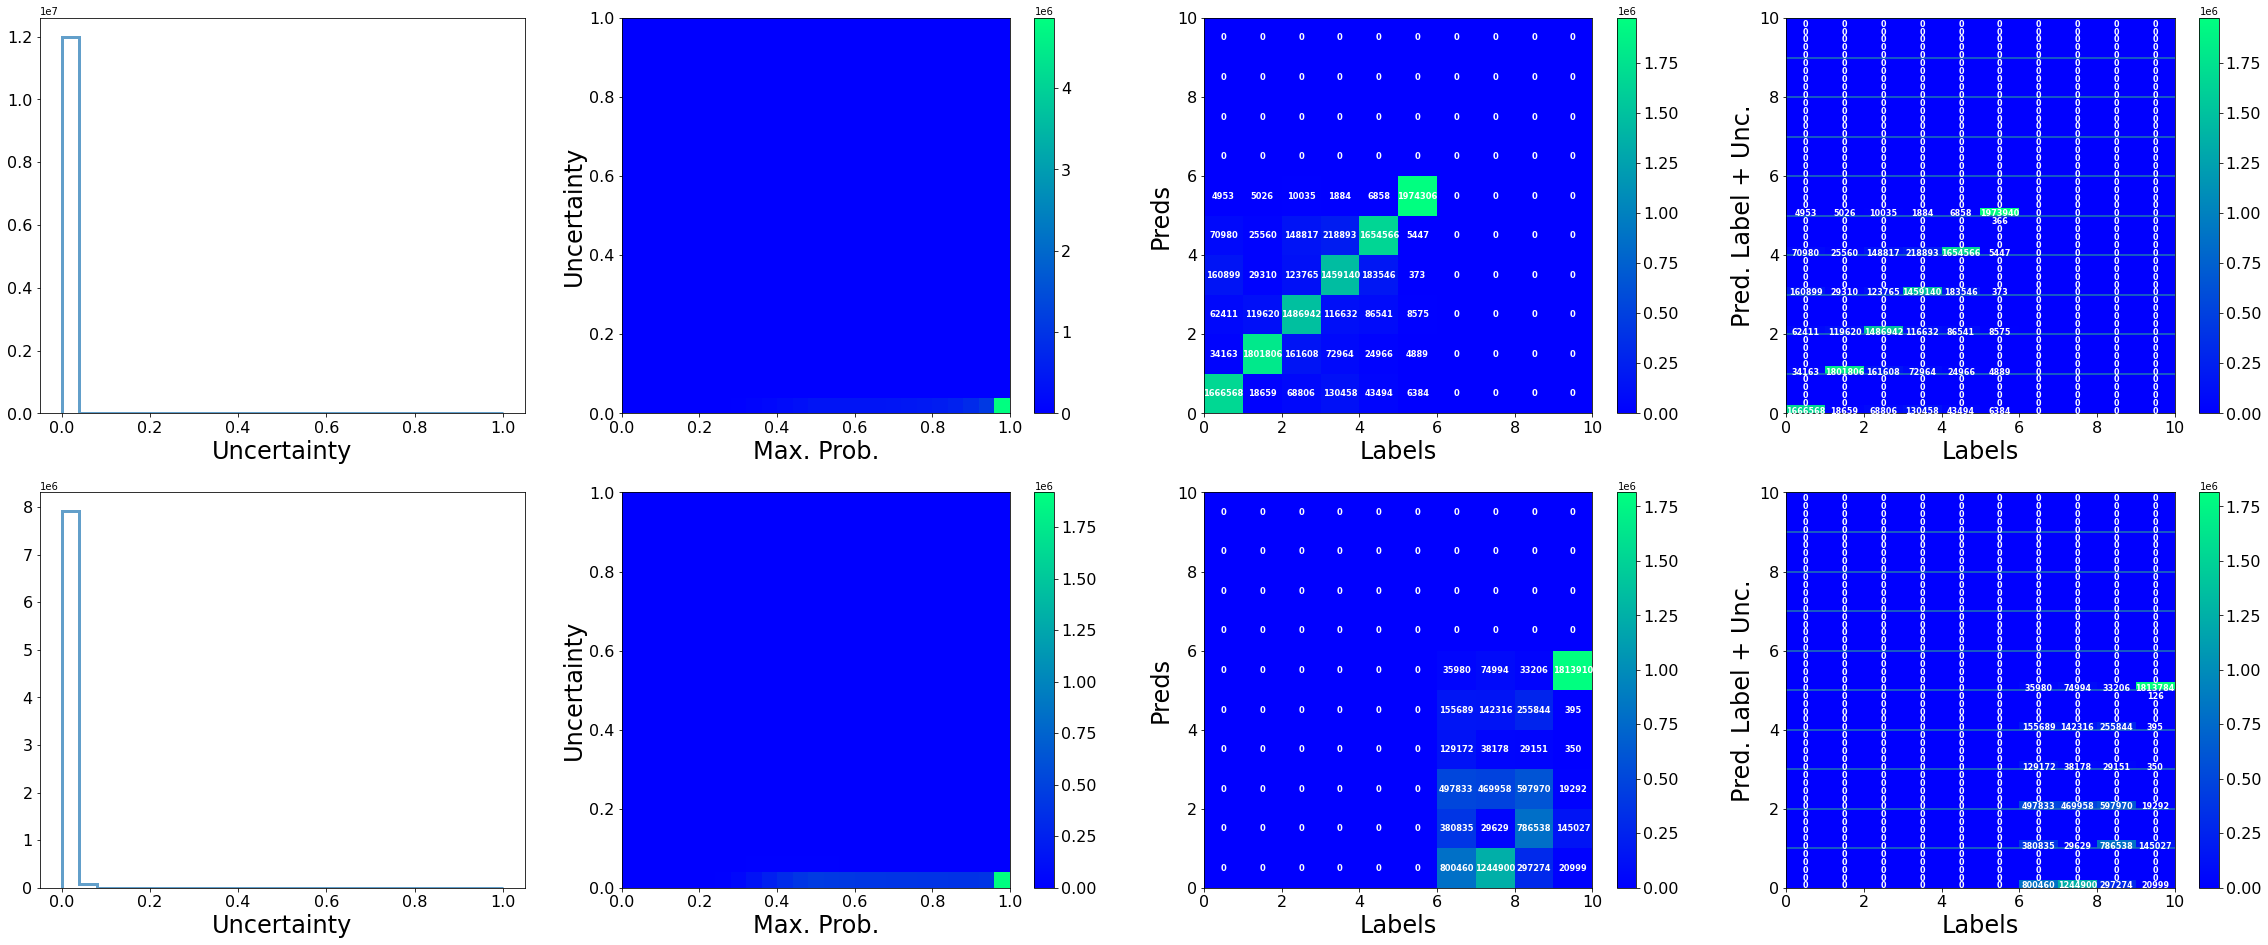

jetclass_0_skipwz


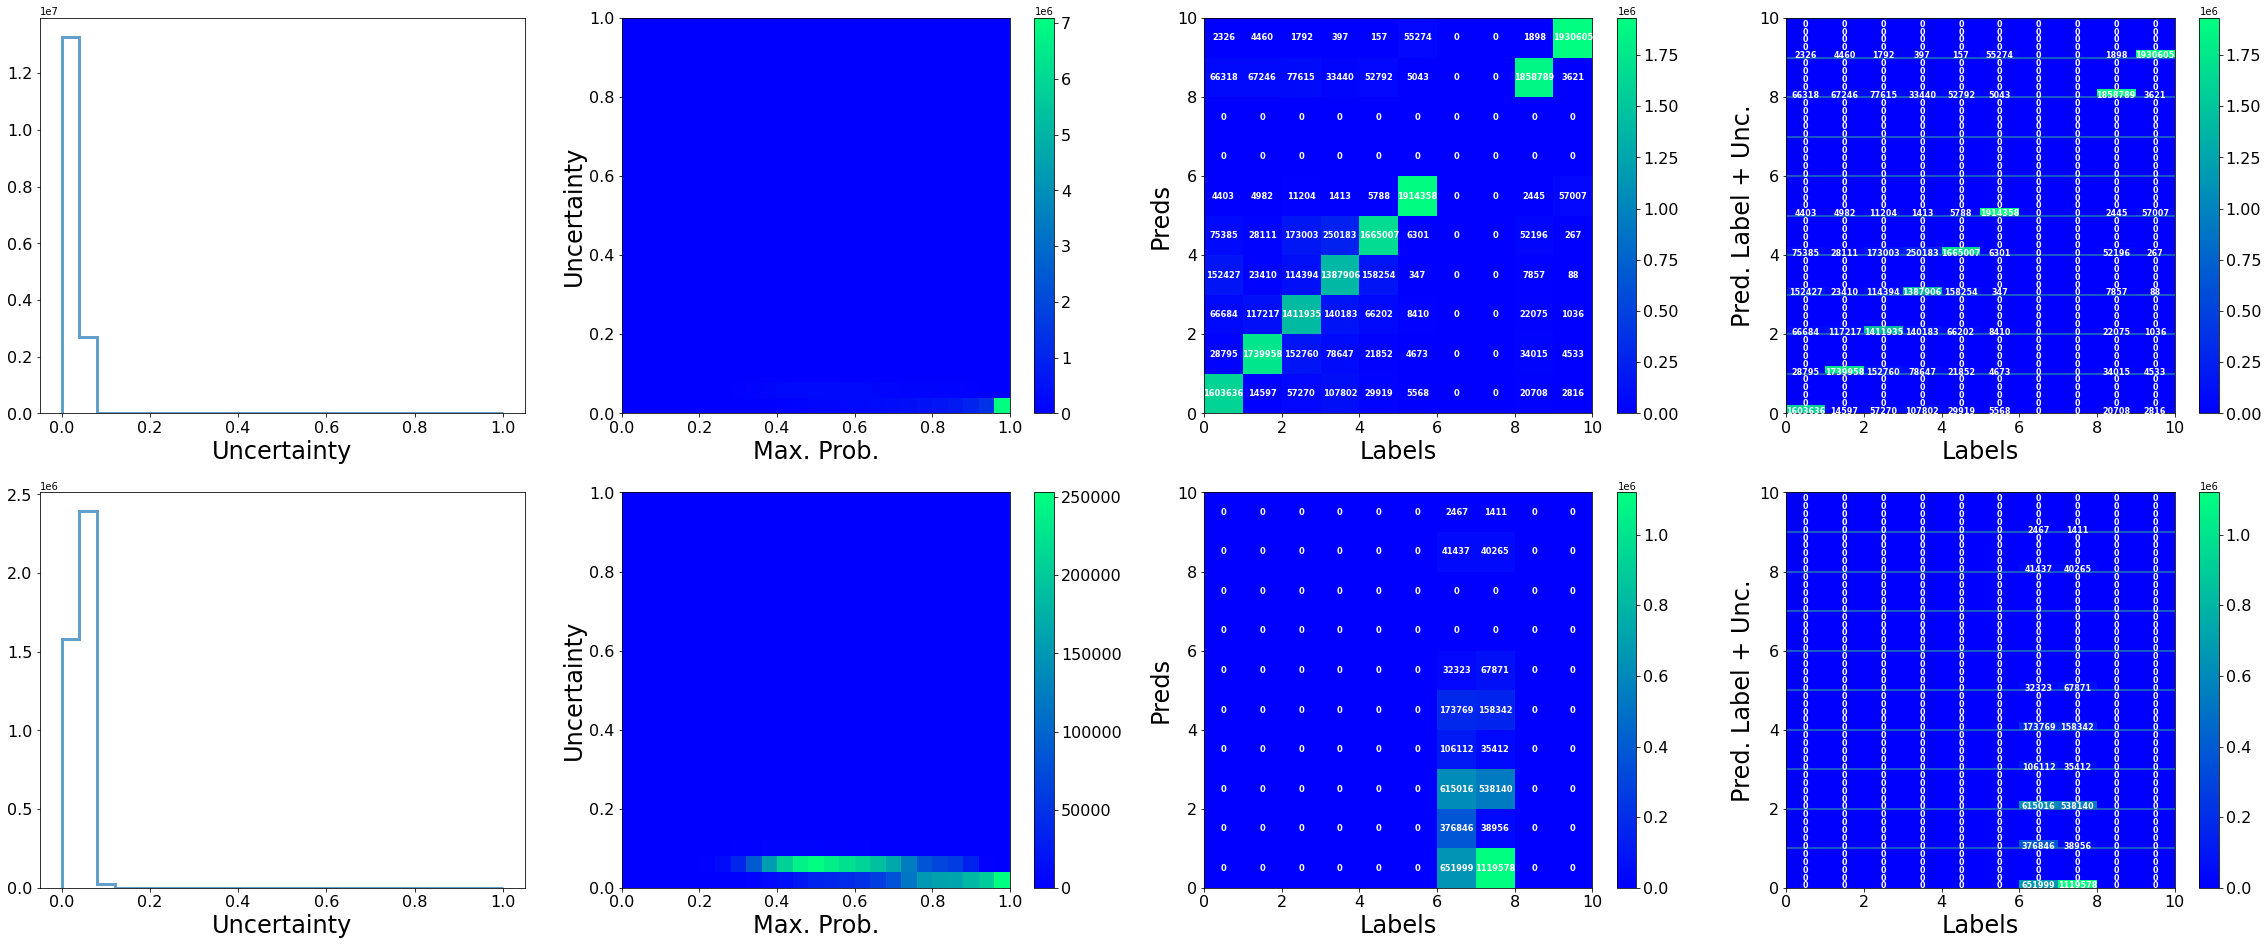

jetclass_0_v1_skiptop


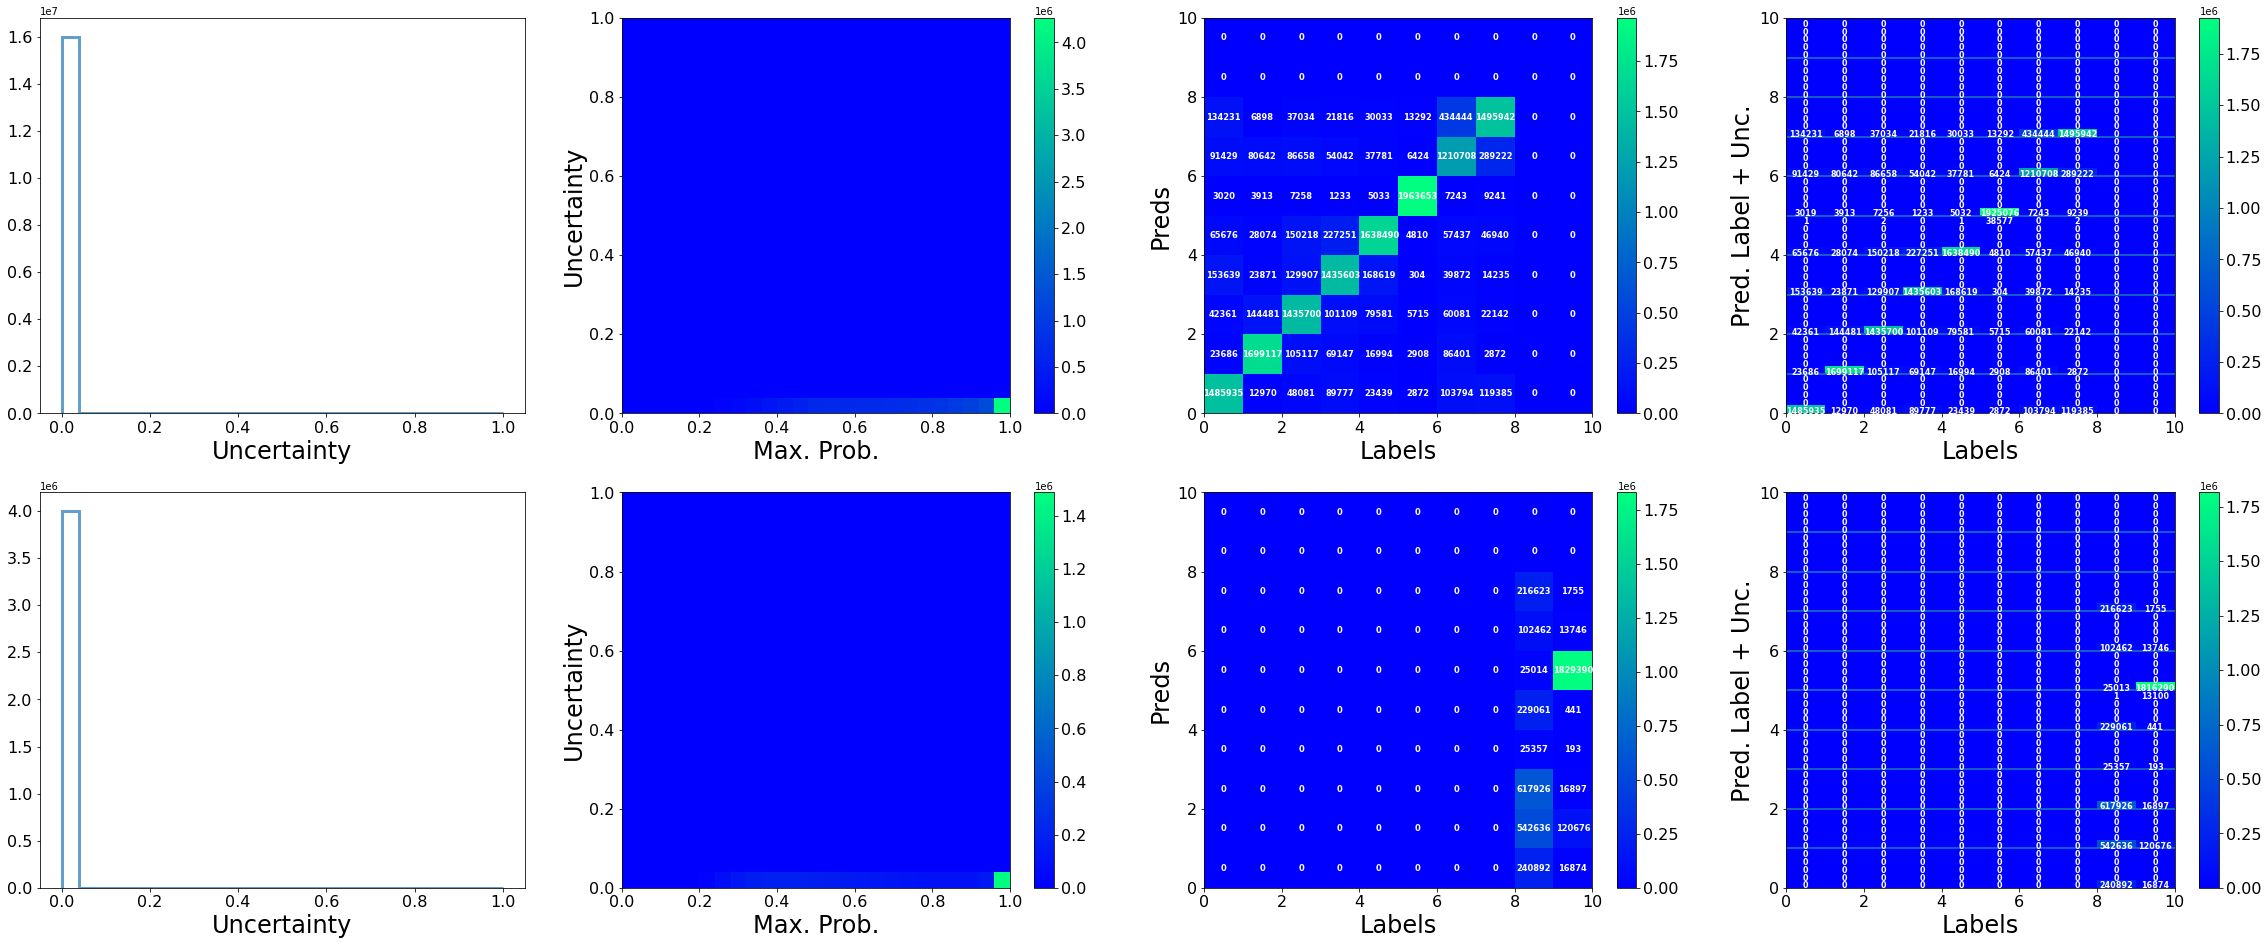

jetclass_nominal_0.1_v0_skiptwz


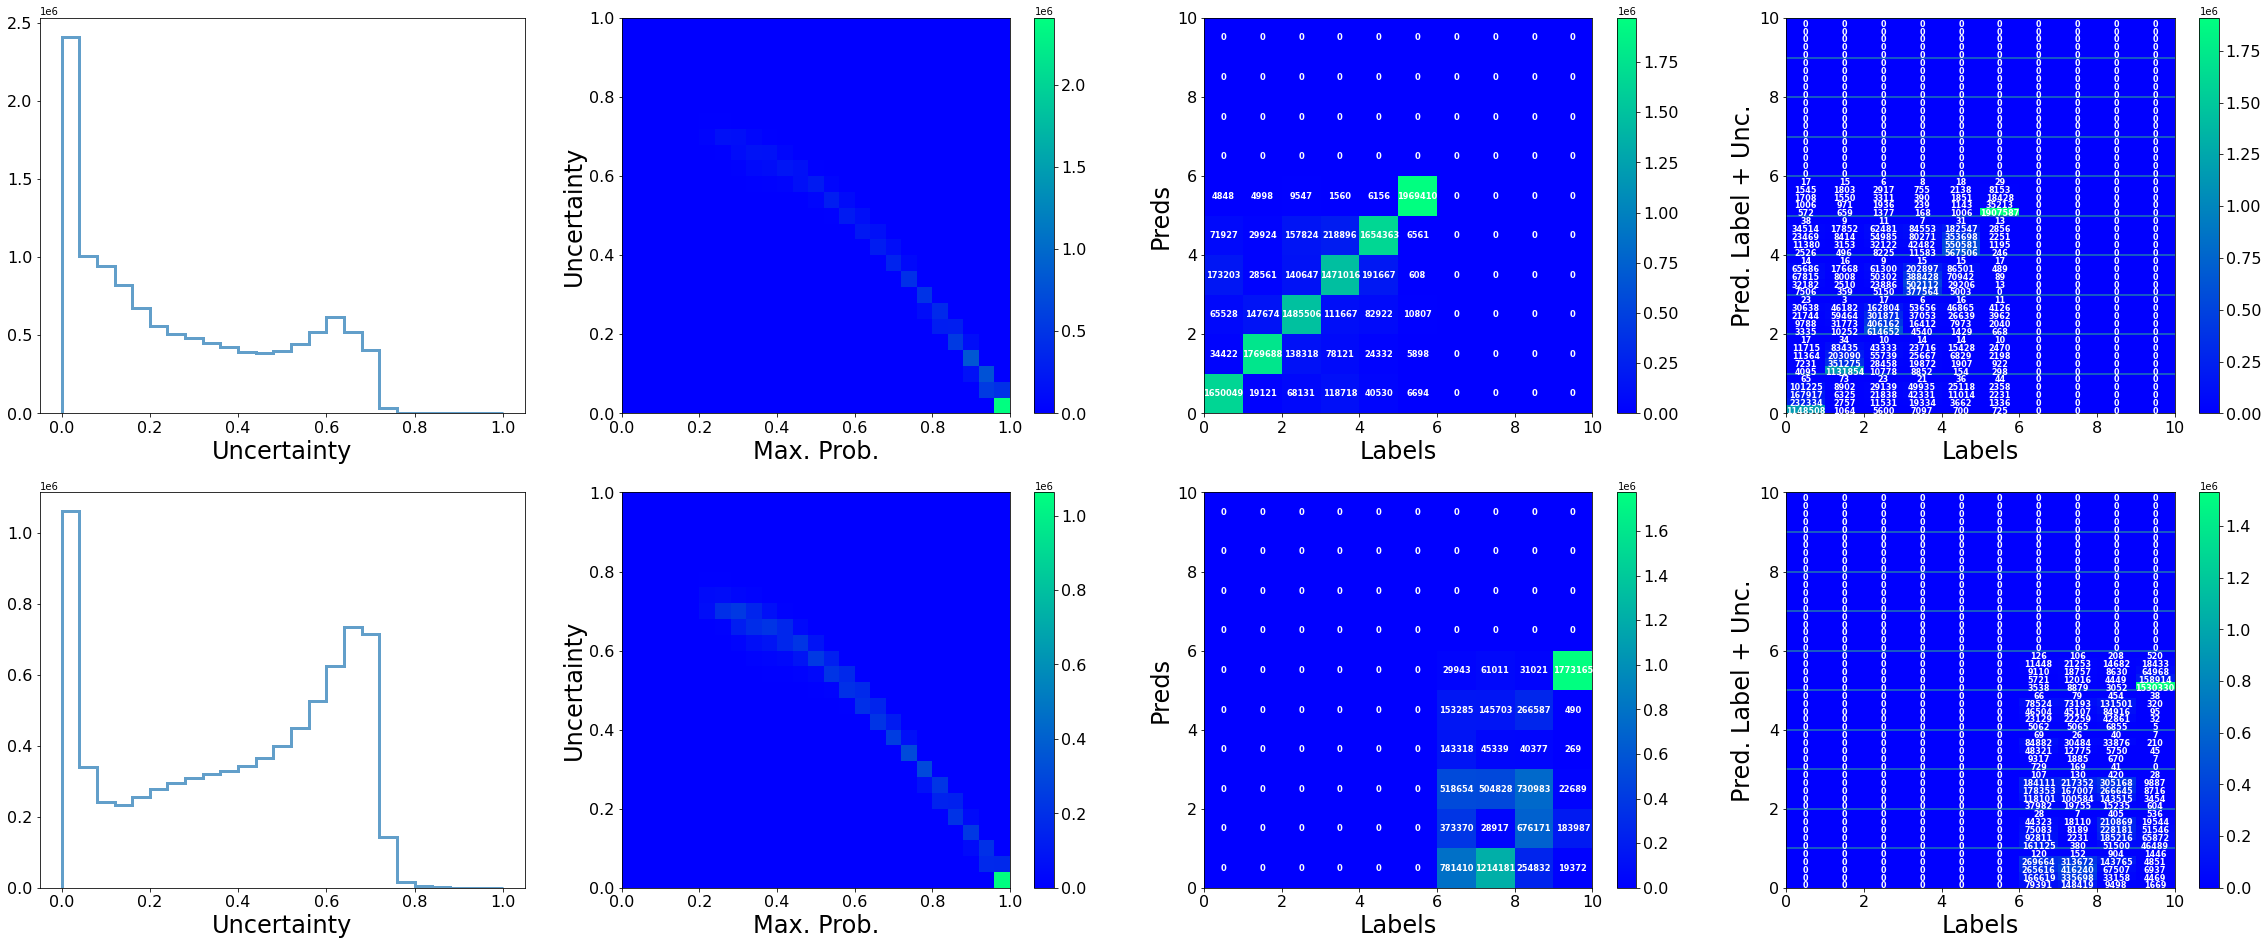

jetclass_nominal_0.1_v1_baseline


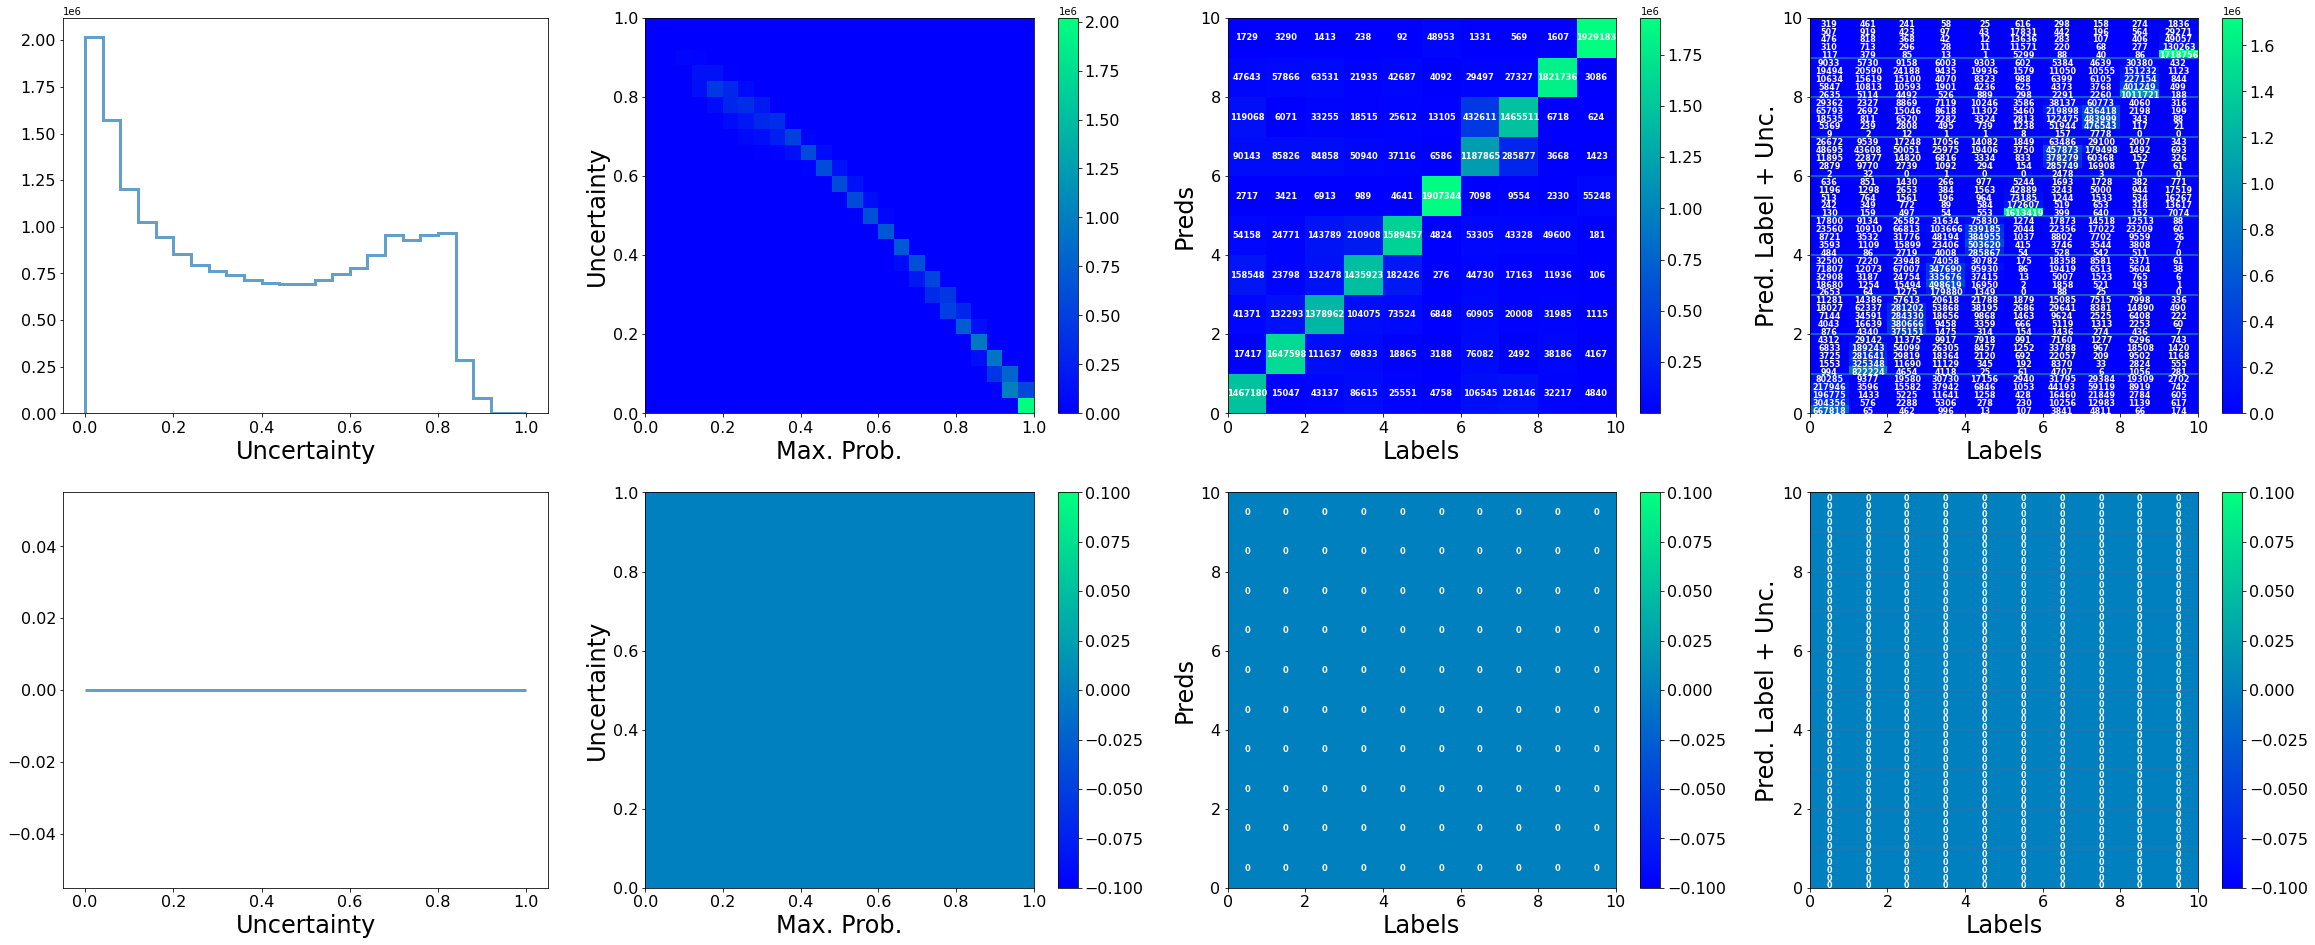

jetclass_nominal_0.1_v1_skiph


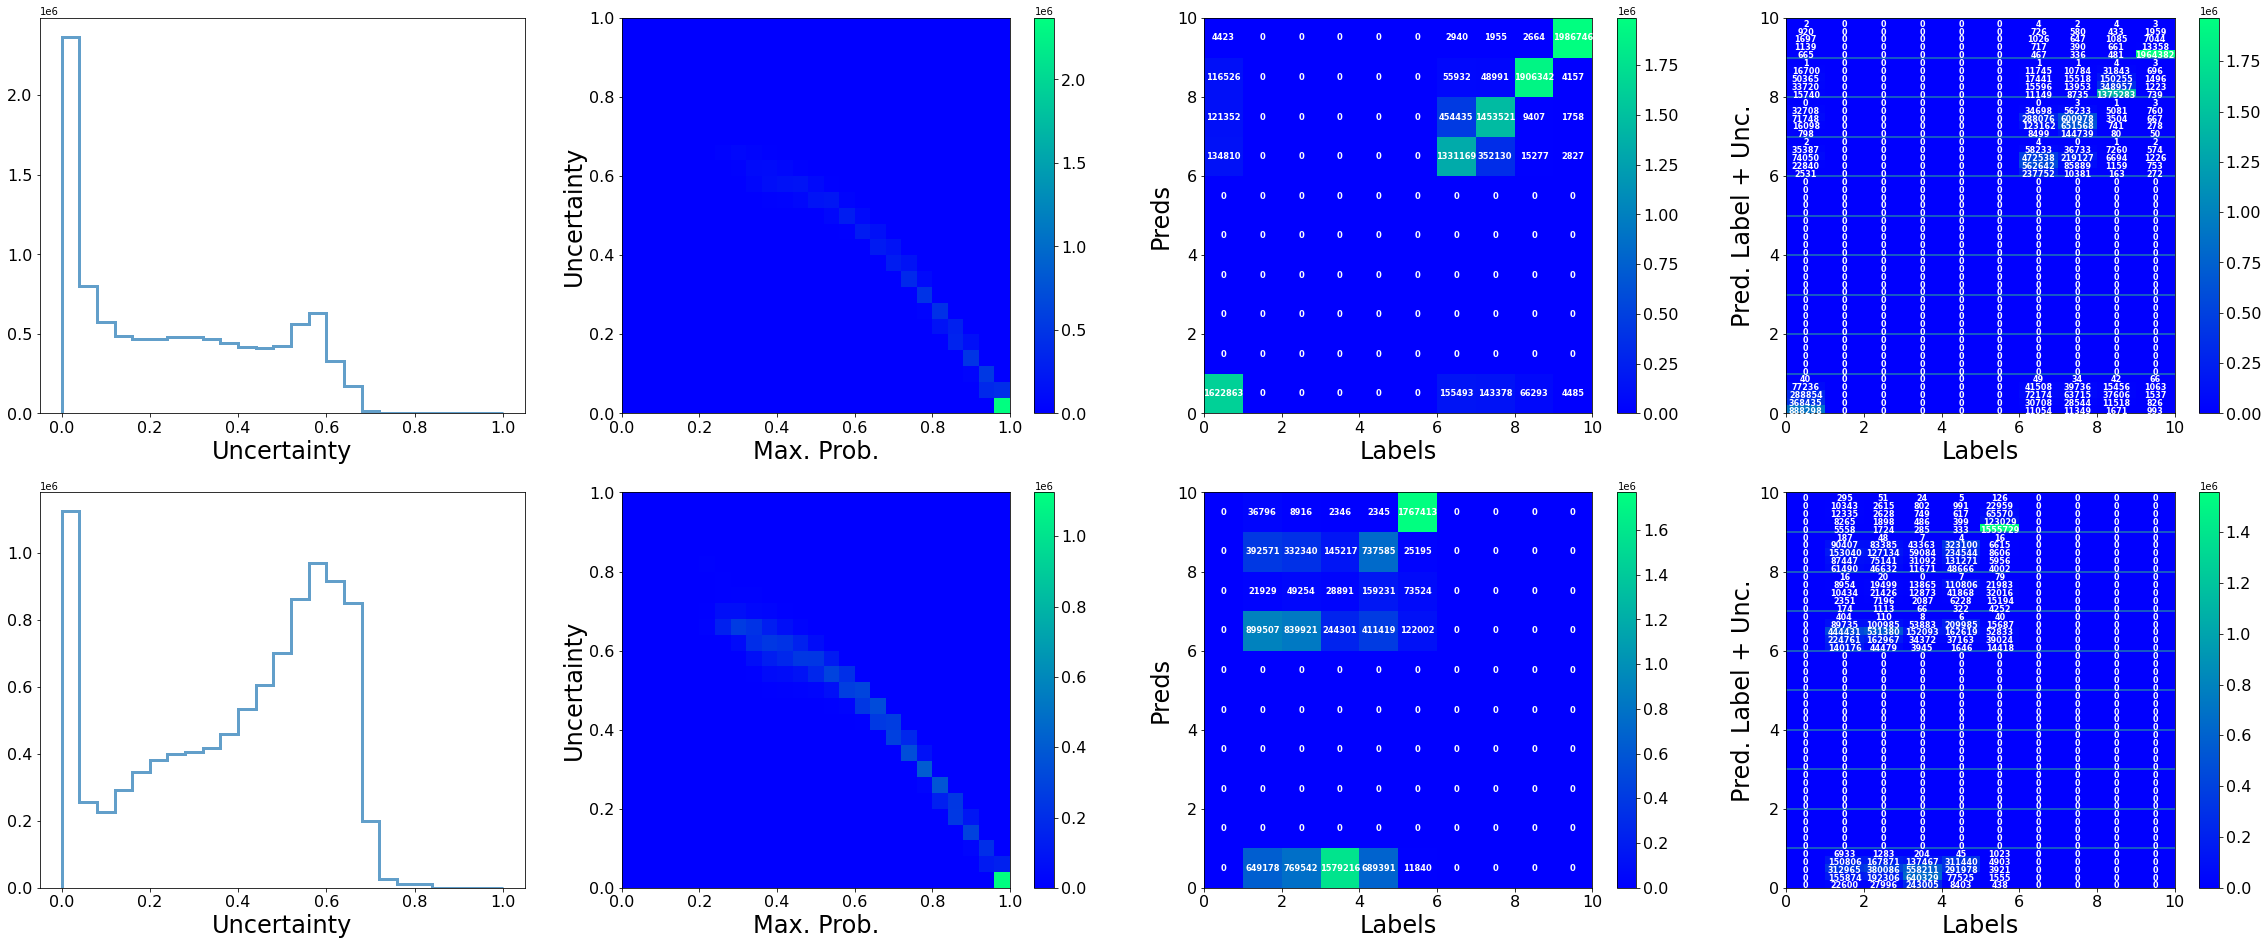

jetclass_nominal_0.1_v1_skiptop


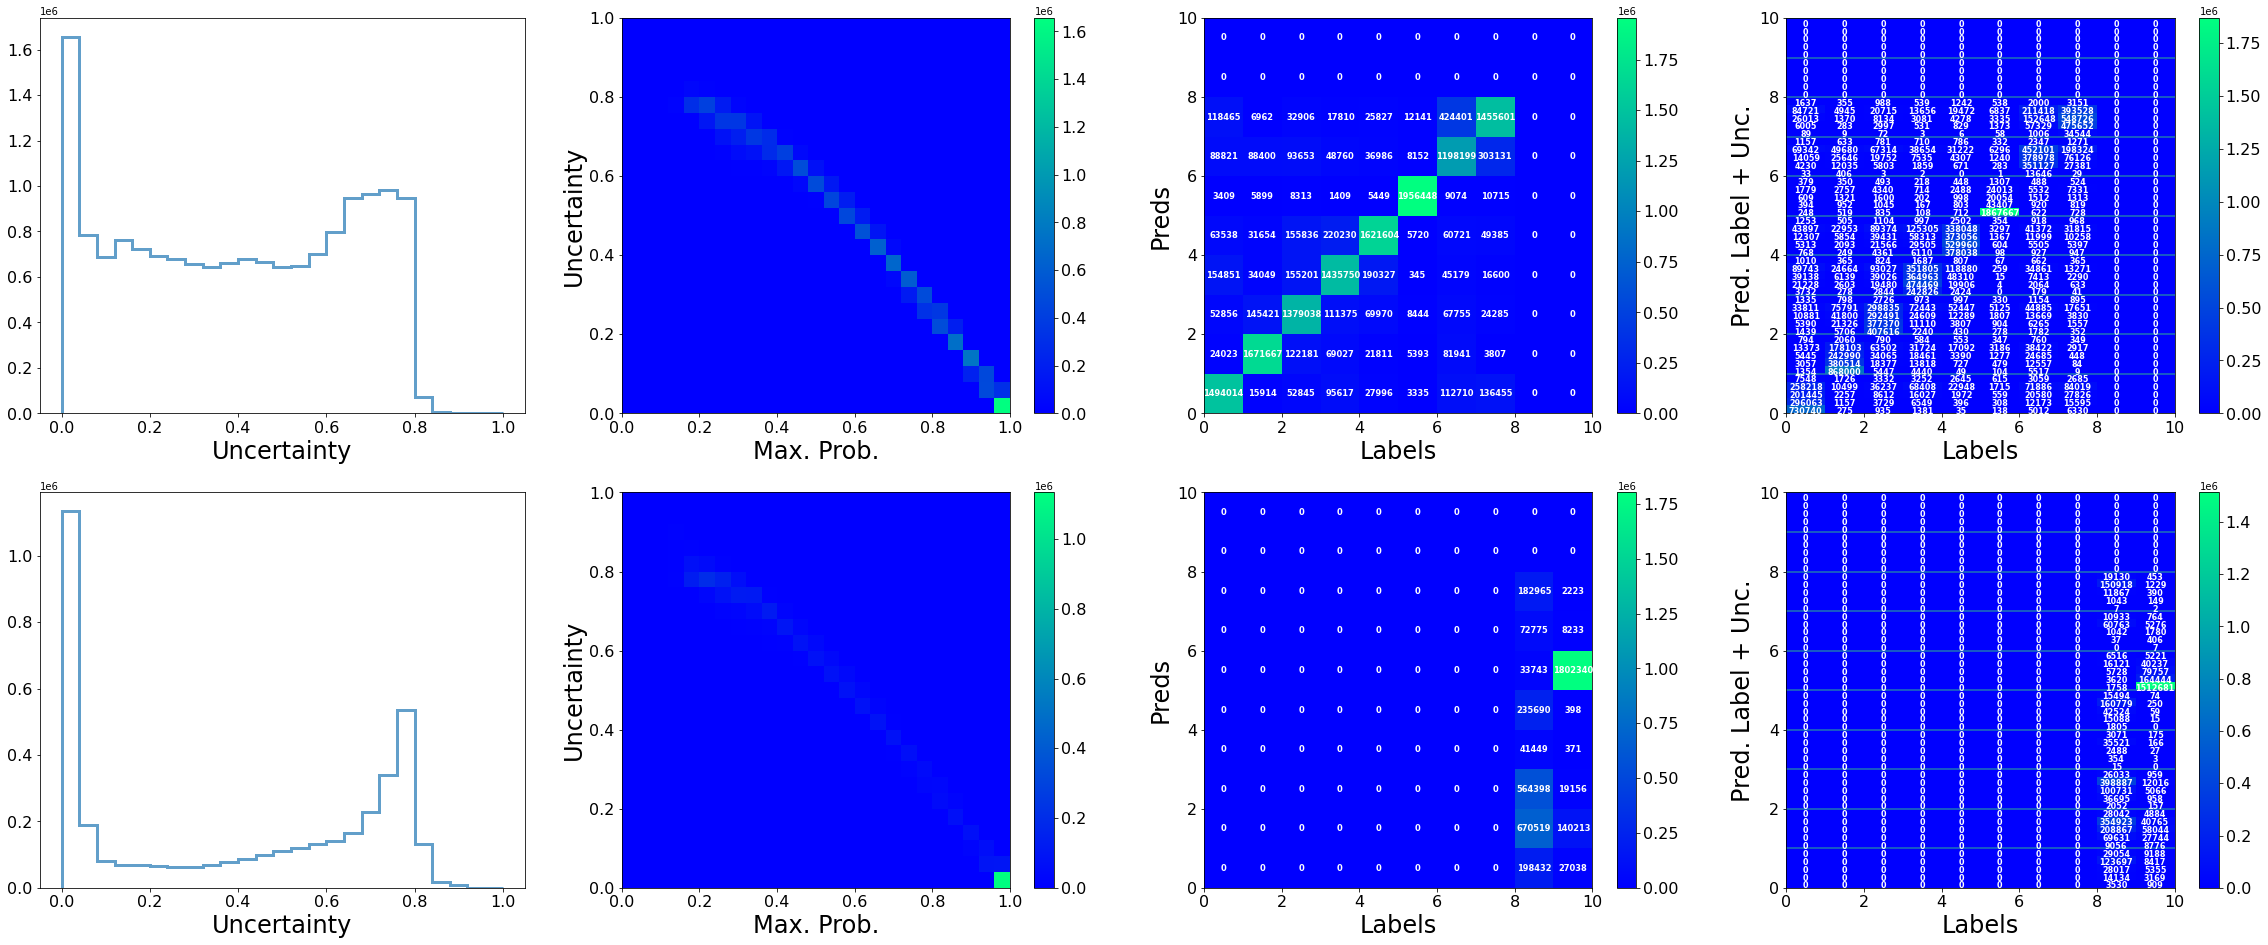

jetclass_nominal_0.1_v1_skipwz


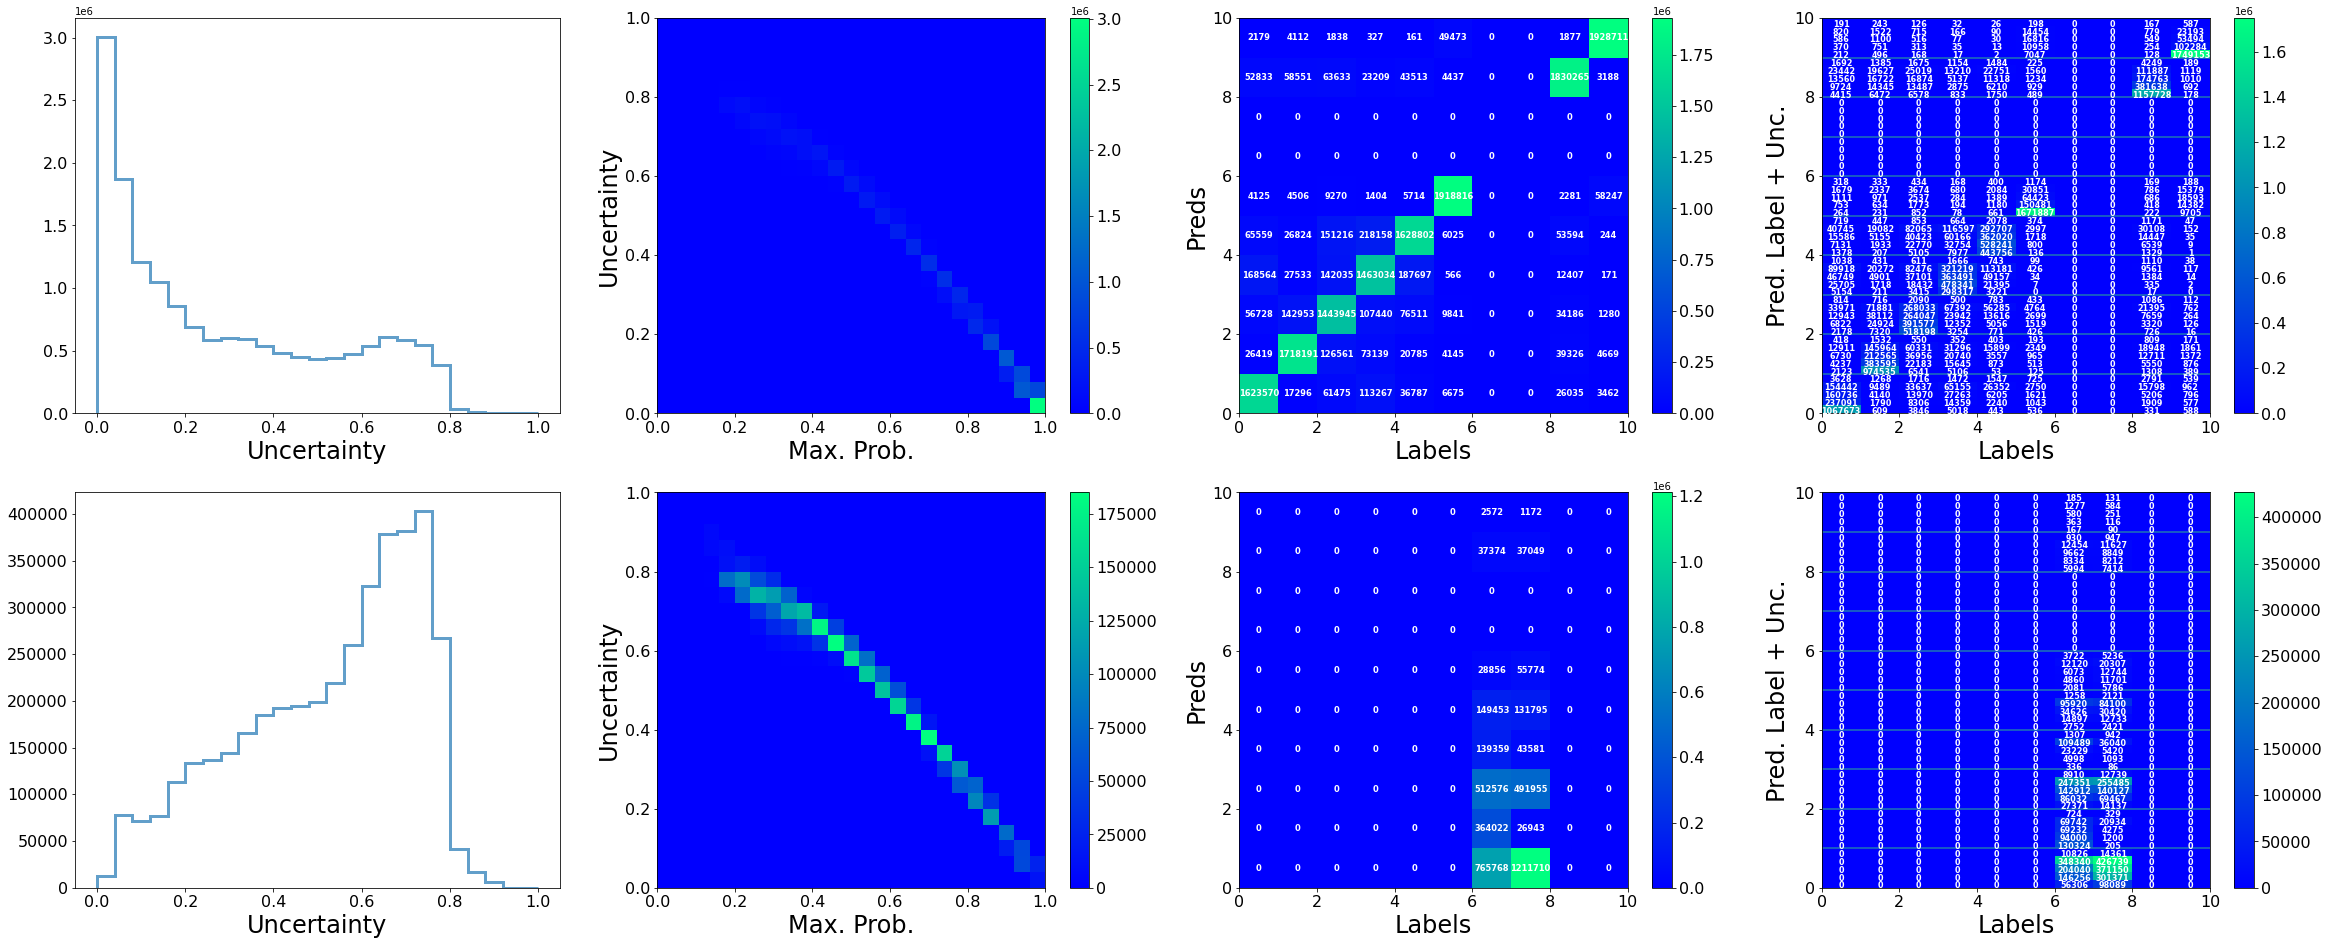

jetclass_nominal_v1_skiph


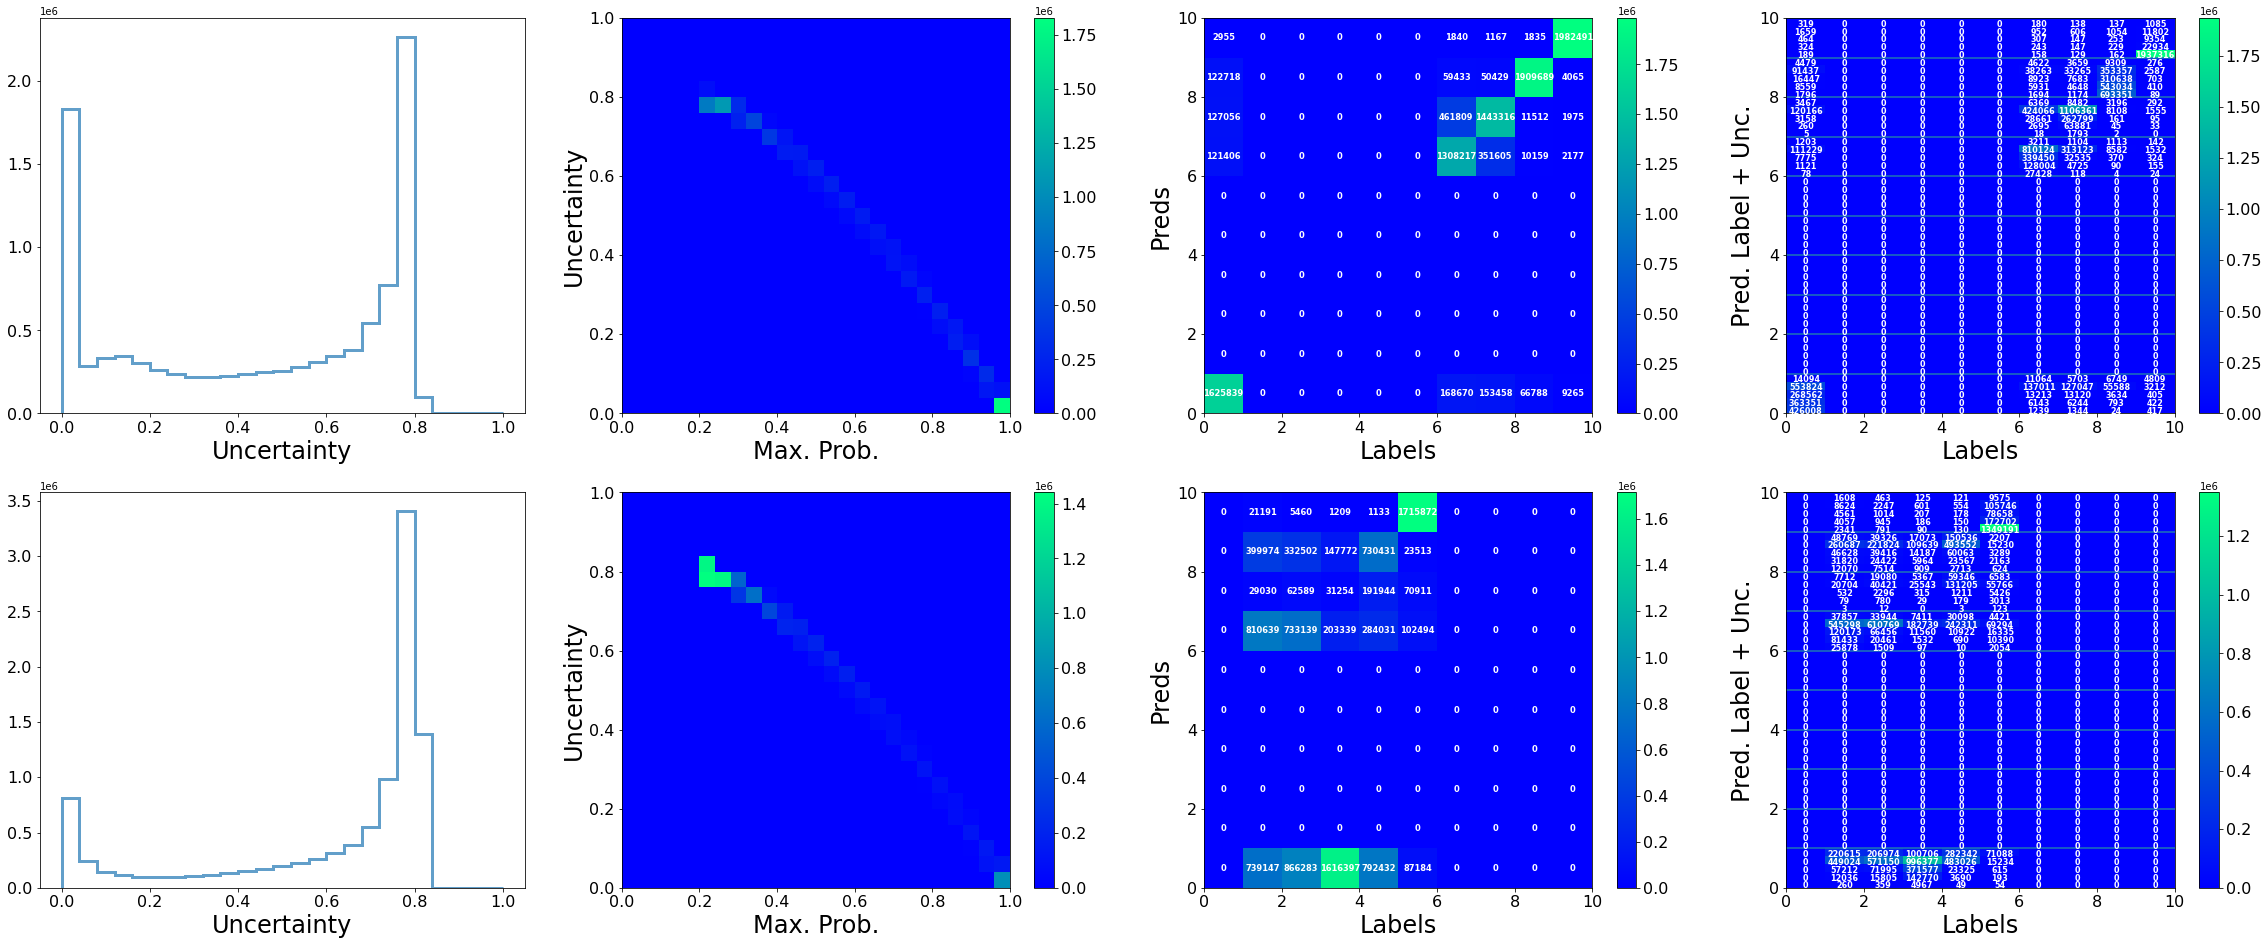

jetclass_nominal_v1_skipwz


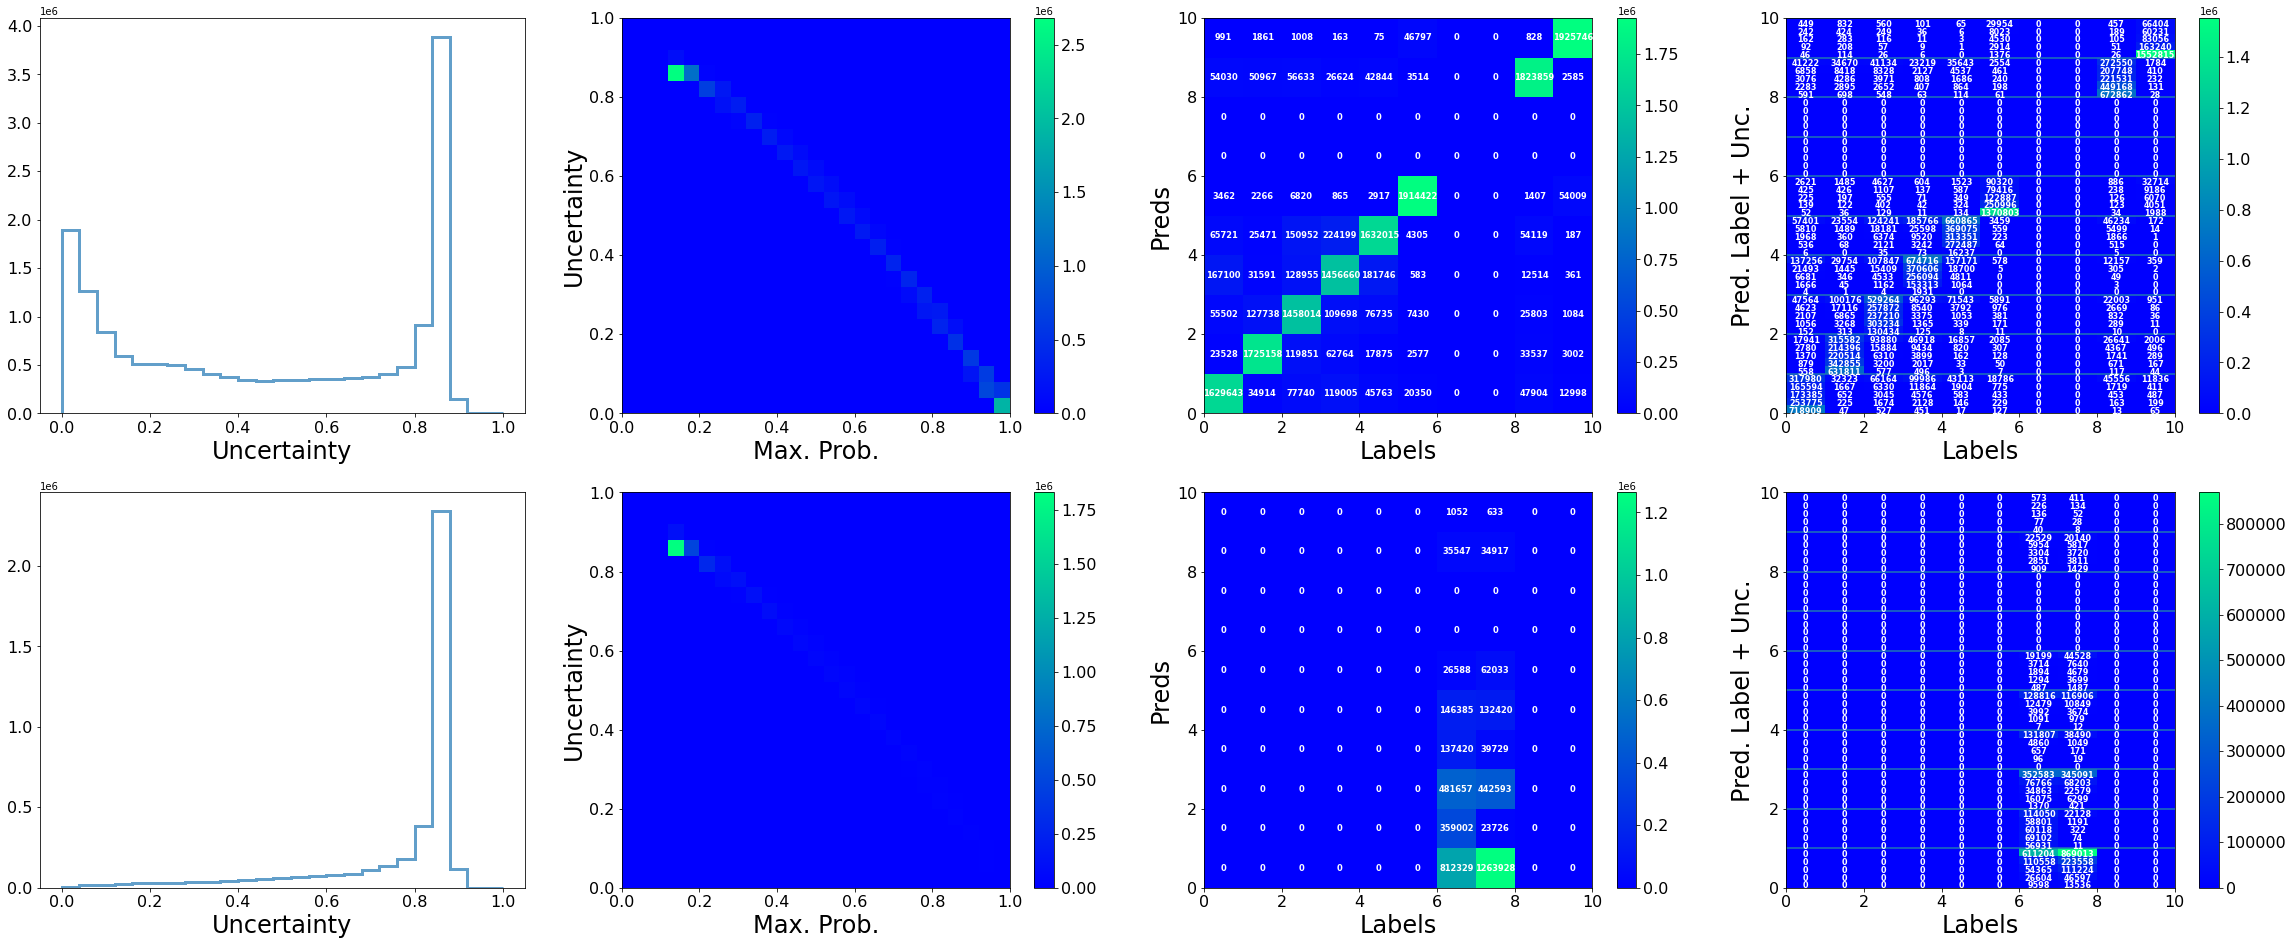

jetclass_nominal_v2_baseline


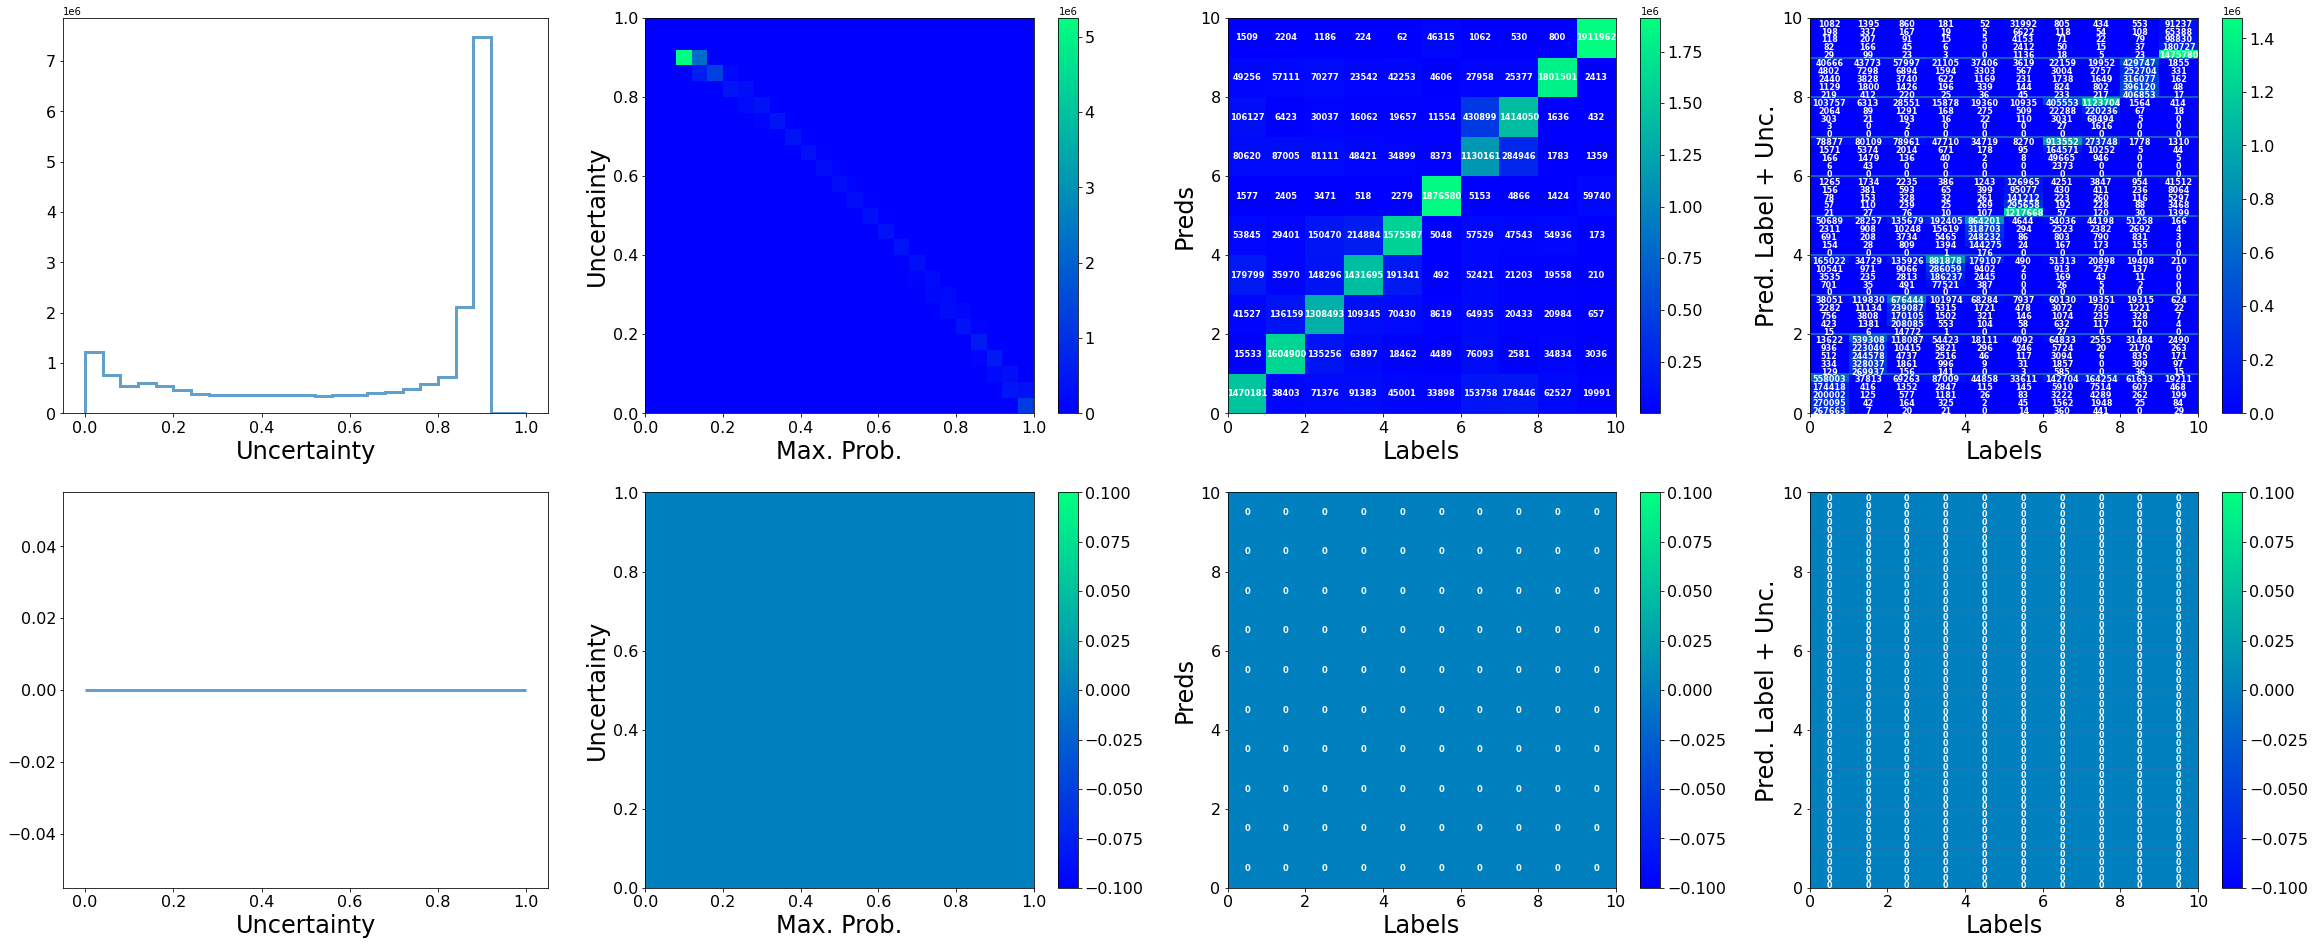

jetclass_nominal_v2_skiptop


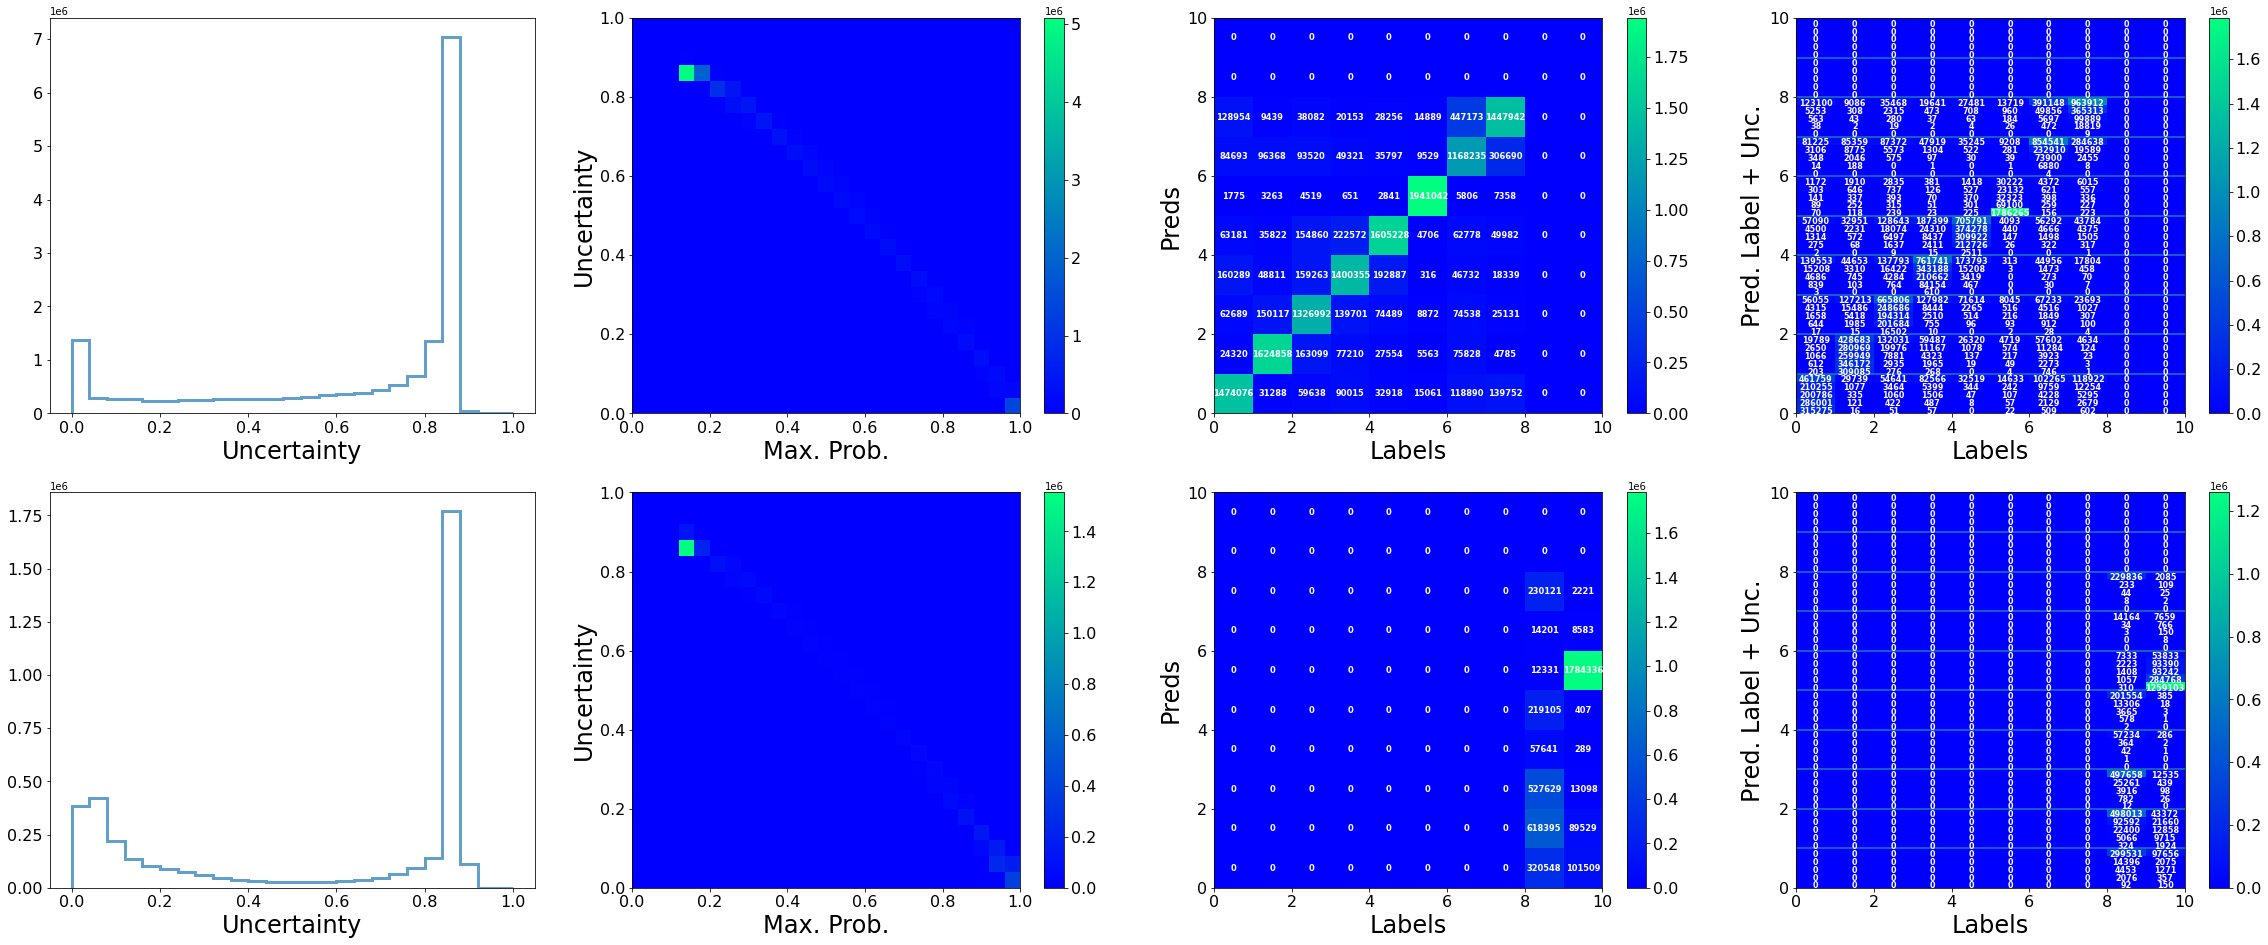

jetclass_nominal_v2_skiptwz


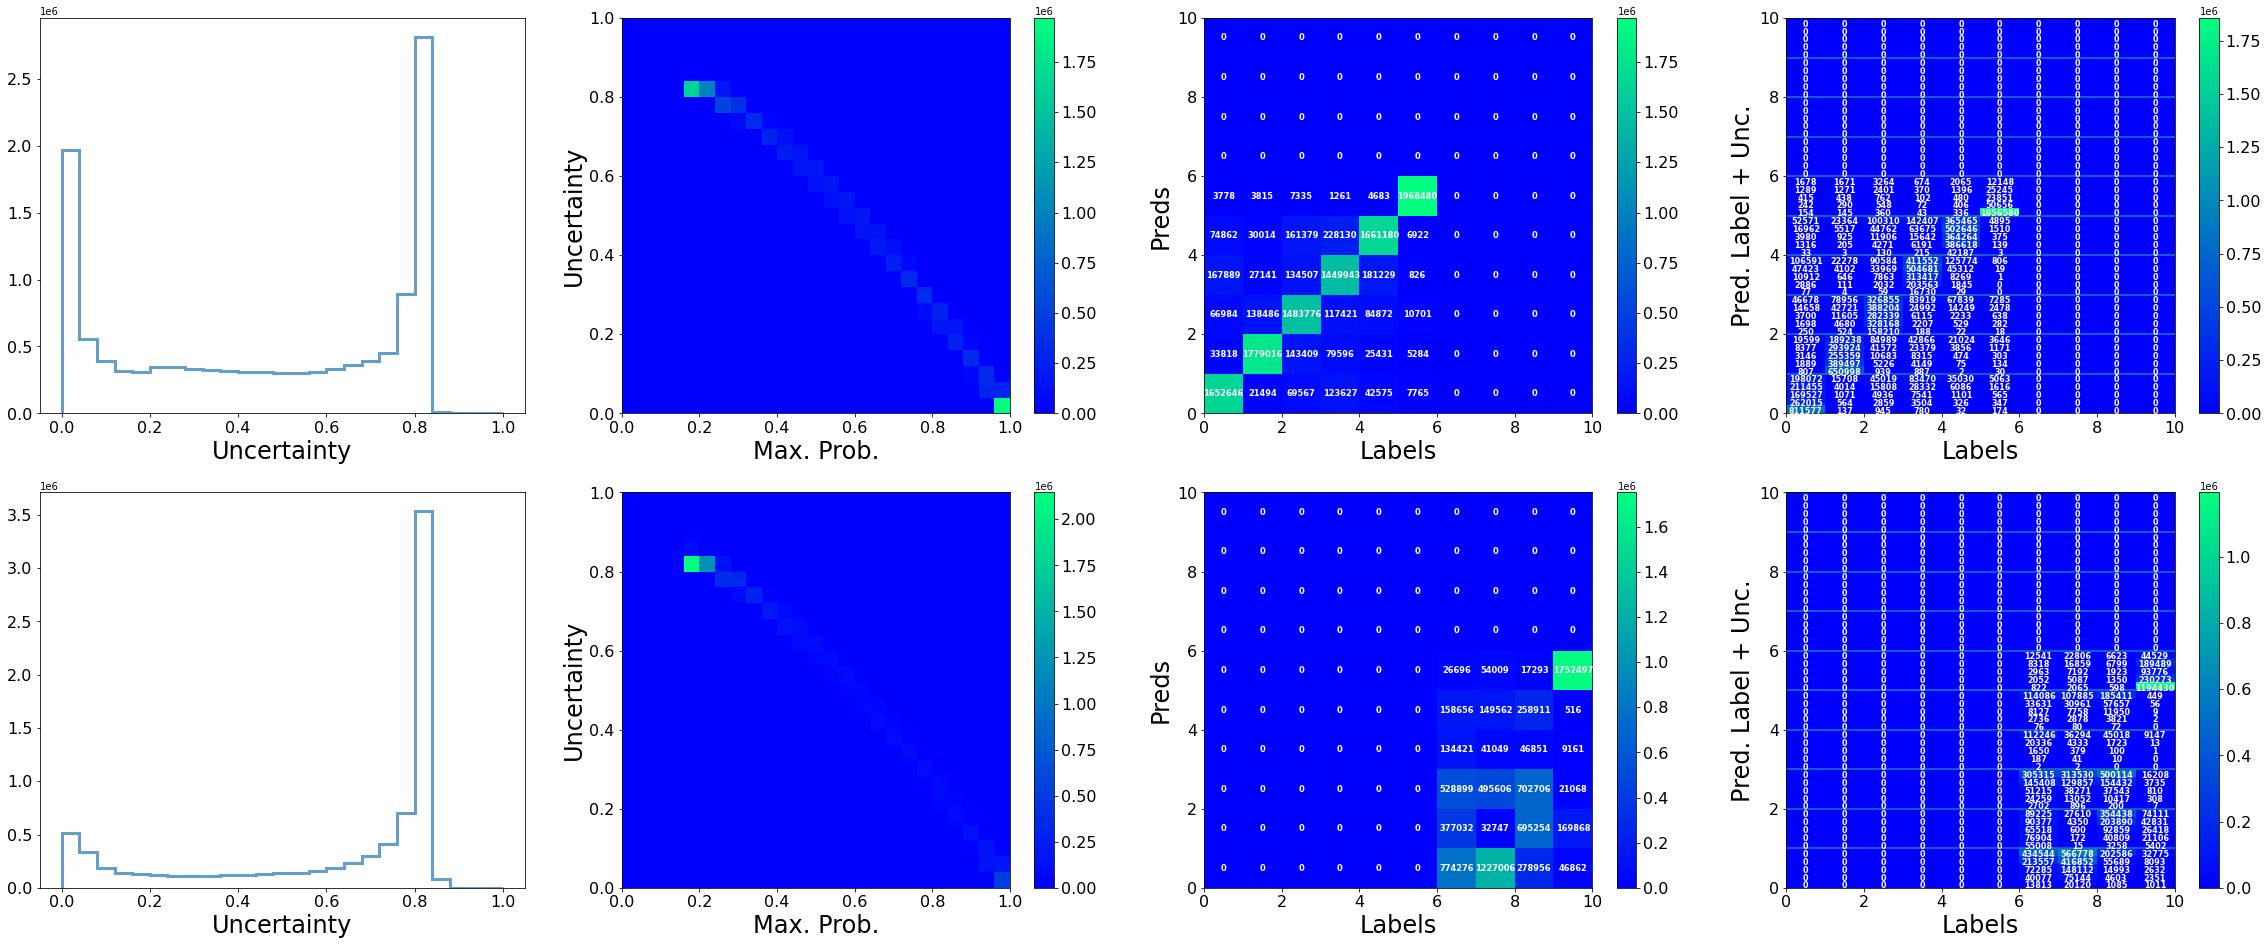

In [7]:
for modelname in result_files:
    key = modelname[20:-3]
    print(key)
    if "jetnet" in key:
        l_max = 5.1
        
        asize=16
        asize2=12
        
    elif "jetclass" in key:
        l_max = 10.1
        
        asize="small"
        asize2=8
    
    elif "JNqgmerged" in key:
        l_max = 4.1
    else:
        l_max = 2.1
        
        asize=32
        asize2=20
    
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")    
    labels, preds, maxprobs, sums, oods, uncs, probs = f['labels'][:], f['preds'][:], \
                                                f['maxprobs'][:], f['sums'][:], \
                                                f['oods'][:], f['uncs'][:], f['probs'][:]
    f.close()
    
    fsize=24
    tsize=16
    
    if not use_std_unc:
        #epistemic uncertainty
        uncertainty_plot(uncs, oods, maxprobs, labels, preds, key, l_max, fsize, tsize, asize, asize2)
        plt.savefig("figures/EDL_{}.pdf".format(key))
    else:
        # dirichlet distribution std
        sums = torch.from_numpy(sums).reshape(-1,1)
        probs = torch.from_numpy(probs)
        uncs = torch.sqrt(((probs*(1 - probs))/(sums + 1))).sum(1).numpy()
        uncertainty_plot(uncs, oods, maxprobs, labels, preds, key, l_max, fsize, tsize, asize, asize2)
        plt.savefig("figures/STD_{}.pdf".format(key))
    
    plt.show()